# Mobilités professionnelles : statistiques nationales de l'INSEE

&#127919; **Objectif du notebook** : présenter un traitement de données de recensement de l'INSEE sur les mobilités professionnelles des français, avec un focus sur les données géographiques.

&#128218; **Données** : Données INSEE du recensement 2016 sur les mobilités professionnelles rendues disponibles en 2018 (N = 7 824 392) https://www.insee.fr/fr/statistiques/4171531?sommaire=4171558 complétées par d'autres données INSEE agrégées à l'échelle des communes.

&#10067; **Question de recherche**: comment caractériser à l'échelle nationale les pratiques de mobilités des français ? Comment se structure l'espace géographique des trajets travail/domicile des français ?

<div class="alert alert-block alert-warning">
<b>Philosophie générale</b> 
     <br>

&#10148; Notebook construit selon un modèle narratif linéaire exécutable ; <br>
    
&#10148; Prioritée donné à la lisibilité en détaillant les étapes (forte verbosité ; une cellule par étape) ; <br>

&#10148; Application des bonnes pratiques de programmation en langage Python &#128013; (structure avec [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/#directory-structure) et [Black](https://black.readthedocs.io/en/stable/index.html) pour le code) ; <br>
   
&#10148; Séparation données/traitement (entre les données brutes et le code, et dans le code) ; <br>
        
&#10148; Recherche d'un équilibre entre minimisation du nombre de bibliothèques et facilité d'usage ; <br>
            
&#10148; Documentation du code respectant les standards ([numpydoc docstrings](https://numpydoc.readthedocs.io/en/latest/format.html) utilisé notamment par [scikit-learn](https://scikit-learn.org/stable/)); <br>
    
&#10148; Mention explicite des versions de bibliothèques utilisées ; <br>

</div>

## Contexte

### Données

Nous utiliserons plusieurs données différentes, ouvertes &#128275; et disponibles sur le site de l'INSEE. 

&#128218; Données du recensement 2016 sur les mobilités professionnelles rendues disponibles en 2018 (N = 7 824 392) https://www.insee.fr/fr/statistiques/4171531?sommaire=4171558

- Données bilocalisées décrivant les caractéristiques des individus actifs ayant un emploi et âgés de 15 ans ou plus, de son ménage, de sa résidence principale et la localisation de la commune de domicile et de travail.

&#128218; Pour avoir des informations sur la commune à proprement parler, le descriptif des communes sur différentes variables : https://www.insee.fr/fr/statistiques/5359146

&#128218; Des fonds de carte extraits d'OpenStreetMap qui permettent de représenter spatialement les informations localisées.

Comme elles sont volumineuses, il est préférable de les télécharger en local pour les ouvrir, surtout si le notebook doit être exécuté plusieurs fois.


### Démarche  générale

1. Charger les données, les explorer et les transformer pour permettre les analyses ;

2. Réaliser des cartes à partir des informations géographiques ;

3. Réduire la dimensionnalité des données avec la classification pour faciliter les modèles ;

4. Construire des modèles.

### Choix de bibliothèques

L'analyse de données administratives INSEE en sciences sociales nécessite trois grands types d'outils :

1. La manipulation de données tabulaires, facilité par la bibliothèque `Pandas`
2. L'association aux données géographiques avec `GeoPandas` complété avec `Geopy` et `Pysal` pour les calculs
3. Les modèles de classification avec `Scikit-Learn` et `Statsmodels`

Le nombre important de bibliothèques s'explique par le fait que nous allons faire de nombreuses opérations dans le notebook. 

Attention : en local, `Geopandas` et `Pysal` peuvent dans certains cas être difficiles à installer.

In [1]:
# décommenter la ligne suivante, puis exécuter cette cellule, pour installer les bibliothèques
# %pip install -r ../requirements.txt

In [2]:
# Modules standards
from pathlib import Path
import zipfile
import pickle

# Requêtes HTTP
import requests

# Tableaux
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Géographie
import geopandas as gpd
from geopy.distance import geodesic
import pysal as ps

# Analyse de réseaux
import networkx as nx

# Statistiques
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import pyshs
import prince

## 1. Chargement des données

Assurons-nous d'abord d'avoir accès aux données. Pour cela, nous téléchargeons les données en local si elles ne sont pas encore téléchargées.

In [3]:
def download(url, destination):
    """Télécharge la ressource depuis une URL vers un emplacement local.

    Lève une exception si le dossier de la destination n'existe pas.

    Parameters
    ----------
    url : string
        URL de la ressource à télécharger
    destination : Path
        Chemin de destination (local).
    """
    if not destination.parent.is_dir():
        raise ValueError(
            f"Le dossier de la destination n'existe pas: {destination.parent}"
        )
    if destination.is_file():
        print(f"Le fichier local existe déjà: {destination}")
    else:
        r = requests.get(
            url, verify=False
        )  # demander le fichier / attention, security check disabled
        open(destination, "wb").write(r.content)  # stocker le fichier en local

In [4]:
# Dossiers de destination sur un stockage gros volume ; à adapter chez vous
data_base = Path("../../notesbooks-shs/mobilites-professionnelles/data")
data_raw = data_base / "raw"
data_raw.mkdir(exist_ok=True)  # on crée le sous-dossier "raw" si besoin
data_interim = data_base / "interim"
data_interim.mkdir(exist_ok=True)  # on crée le sous-dossier "interim" si besoin

In [5]:
# Données à l'échelle des déplacements individuels de l'INSEE
download(
    "https://www.insee.fr/fr/statistiques/fichier/4171531/RP2016_mobpro_csv.zip",
    data_raw / "RP2016_mobpro_csv.zip",
)

# Données à l'échelle des communes de l'INSEE
download(
    "https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip",
    data_raw / "RP2016_dossier_complet.zip",
)

# Carte des communes de OSM
download(
    "https://osm13.openstreetmap.fr/~cquest/openfla/export/communes-20220101-shp.zip",
    data_raw / "communes-20220101-shp.zip",
)

# Autre fond de carte avec anamorphose
download(
    "https://www.data.gouv.fr/fr/datasets/r/e29c5d86-c8b0-41db-b913-c19d26195cff",
    data_raw / "carto-communes.gpkg",
)

Le fichier local existe déjà: ../../notesbooks-shs/mobilites-professionnelles/data/raw/RP2016_mobpro_csv.zip
Le fichier local existe déjà: ../../notesbooks-shs/mobilites-professionnelles/data/raw/RP2016_dossier_complet.zip
Le fichier local existe déjà: ../../notesbooks-shs/mobilites-professionnelles/data/raw/communes-20220101-shp.zip
Le fichier local existe déjà: ../../notesbooks-shs/mobilites-professionnelles/data/raw/carto-communes.gpkg


Nous pouvons maintenant ouvrir les données qui sont des archives zip avec plusieurs fichiers dedans.

(attention, les fichiers sont lourds, l'opération peut prendre du temps en local)

In [6]:
# Chargement des données à l'échelle des individus
zip_file = zipfile.ZipFile(data_raw / "RP2016_mobpro_csv.zip")  # zip_file.infolist()
meta_ind = pd.read_csv(
    zip_file.open("Varmod_MOBPRO_2016.csv"),
    sep=";",
    dtype={
        "COD_VAR": "category",
        "LIB_VAR": "category",
        "COD_MOD": "category",
        "LIB_MOD": "category",
        "TYPE_VAR": "category",
    },
)
data_ind = pd.read_csv(
    zip_file.open("FD_MOBPRO_2016.csv"),
    sep=";",
    low_memory=False,
    dtype={
        "COMMUNE": "category",
        "ARM": "category",
        "DCFLT": "category",
        "DCLT": "category",
        "AGEREVQ": "category",
        "CS1": "category",
        "DEROU": "category",
        "DIPL_15": "category",
        "EMPL": "category",
        "ILT": "category",
        "ILTUU": "category",
        "IMMI": "category",
        "INATC": "category",
        "INEEM": "category",
        "INPOM": "category",
        "INPSM": "category",
        "IPONDI": "float",
        "LPRM": "category",
        "METRODOM": "category",
        "MOCO": "category",
        "NA5": "category",
        "NPERR": "category",
        "REGION": "category",
        "REGLT": "category",
        "SEXE": "category",
        "STAT": "category",
        "STOCD": "category",
        "TP": "category",
        "TRANS": "category",
        "TYPL": "category",
        "TYPMR": "category",
        "VOIT": "category",
    },
)
# on libère la mémoire en supprimant la variable avec le zip ouvert
del zip_file

In [7]:
# Chargement des données à l'échelle de la commune
zip_file = zipfile.ZipFile(data_raw / "RP2016_dossier_complet.zip")
meta_com = pd.read_csv(
    zip_file.open("meta_dossier_complet.csv"),
    sep=";",
    dtype={
        "COD_VAR": "category",
        "LIB_VAR": "category",
        "LIB_VAR_LONG": "category",
        "COD_MOD": "category",
        "LIB_MOD": "category",
        "TYPE_VAR": "category",
        "THEME": "category",
        "SOURCE": "category",
    },
)
data_com = pd.read_csv(zip_file.open("dossier_complet.csv"), sep=";", low_memory=False)
# on libère la mémoire en supprimant la variable avec le zip ouvert
del zip_file

In [8]:
# Chargement des deux fonds de carte
carte = gpd.read_file(data_raw / "communes-20220101-shp.zip")
carte_ana = gpd.read_file(data_raw / "carto-communes.gpkg")

Par la suite, nous voulons associer les informations des individus avec celles des communes et des cartes. Pour cela il faut que le code commune d'identification soit identique sur les différents jeux de données. Les clés d'association sont cruciales quand on travaille avec plusieurs tableaux.

Il faut donc s'assurer que chaque code est bien une chaine de caractères de 5 éléments. Si ce n'était pas le cas, il peut être nécessaire de faire des transformations (comme transformer un nombre en chaîne de caractères, en ajoutant si nécessaire des 0 avant).

In [9]:
print(data_ind["COMMUNE"].iloc[0], data_ind["DCLT"].iloc[0], data_com["CODGEO"].iloc[0])
assert type(data_ind["COMMUNE"].iloc[0]) == type(data_ind["DCLT"].iloc[0])
assert type(data_ind["COMMUNE"].iloc[0]) == type(data_com["CODGEO"].iloc[0])

01001 01001 01001


Après vérification des trois champs correspondant aux clés d'association, ils sont déjà corrects. Aucune transformation n'est nécessaire.

Nous définissons aussi deux fonctions qui permettent de circuler plus facilement dans les métadonnées, ici donner le descriptif d'une variable et ses modalités. Une telle approche correspond à fabriquer les outils qui nous aident à exploiter au mieux un jeu de données existant.

In [10]:
def modalites(var, meta):
    """
    Renvoyer les modalités d'une variable à partir des métadonnées
    """
    t = meta.set_index("COD_VAR").loc[var]
    return dict(t.set_index("COD_MOD")["LIB_MOD"])


def description(var, meta):
    """
    Renvoyer la decription d'une variable à partir des métadonnées
    """
    t = meta.set_index("COD_VAR").loc[var]
    return t.iloc[0]

Exemple d'utilisation de ces fonctions :

In [11]:
description("CS1", meta_ind)

LIB_VAR     Catégorie socioprofessionnelle en 8 postes
COD_MOD                                              1
LIB_MOD                       Agriculteurs exploitants
TYPE_VAR                                          CHAR
LONG_VAR                                           1.0
Name: CS1, dtype: object

In [12]:
modalites("CS1", meta_ind)

{'1': 'Agriculteurs exploitants',
 '2': "Artisans, commerçants et chefs d'entreprise",
 '3': 'Cadres et professions intellectuelles supérieures',
 '4': 'Professions Intermédiaires',
 '5': 'Employés',
 '6': 'Ouvriers',
 '7': 'Retraités',
 '8': 'Autres personnes sans activité professionnelle'}

## 2. Statistiques sur les déplacements à l'échelle des déplacements individuels

Nous avons des données de statistiques assez grandes et variées. Elles permettent de réaliser de nombreux traitements. Dans cette première étape, nous nous intéressons au déplacement des individus à l'échelle individuelle.

### 2.1 Repérer et recoder les variables

Une première étape est d'identifier les variables et de recoder en fonction de nos besoins. D'autres variables pourraient être utilisées pour étendre la réflexion, n'hésitez pas à explorer le jeu de données.

- `IPONDI`	Poids de l'individu **pondération**

**Variables dépendantes utilisées :**

- `VOIT`	Nombre de voitures du ménage
- `TRANS`	Mode de transport principal le plus souvent utilisé pour aller travailler

**Variables indépendantes utilisées :**

- `AGEREVQ`	Âge quinquennal en années révolues
- `SEXE`	Sexe
- `CS1`	Catégorie socioprofessionnelle en 8 postes
- `DIPL_15`	Diplôme le plus élevé
- `TYPL`	Type de logement
- `TYPMR`	Type de ménage regroupé (en 9 postes)
- `ILT`	Indicateur du lieu de travail
- `ILTUU`	Indicateur urbain du lieu de travail
- `INPSM`	Nombre de personnes scolarisées du ménage
- `NPERR`	Nombre de personnes du ménage (regroupé)
- `STOCD`	Statut d'occupation détaillé du logement
- `DCLT`	Département, commune et arrondissement municipal (Paris, Lyon, Marseille) du lieu de travail
- `COMMUNE`	Département et commune du lieu de résidence

Nous recodons les principales variables d'intérêt à partir des modalités des métadonnées pour faciliter la lecture. D'autres codages pourraient être pensés suivant la question posée. Dans ce cas, nous nous contentons d'utiliser les labels fournis par les métadonnées, en utilisant la méthode `replace` et notre fonction qui récupère les métadonnées.

In [13]:
data_ind["SEXE_reco"] = (
    data_ind["SEXE"].replace(modalites("SEXE", meta_ind)).astype("category")
)
data_ind["TRANS_reco"] = (
    data_ind["TRANS"].replace(modalites("TRANS", meta_ind)).astype("category")
)
data_ind["CS1_reco"] = (
    data_ind["CS1"].replace(modalites("CS1", meta_ind)).astype("category")
)
data_ind["DIPL_reco"] = (
    data_ind["DIPL_15"].replace(modalites("DIPL_15", meta_ind)).astype("category")
)
data_ind["TYPL_reco"] = (
    data_ind["TYPL"].replace(modalites("TYPL", meta_ind)).astype("category")
)
data_ind["STOCD_reco"] = (
    data_ind["STOCD"].replace(modalites("STOCD", meta_ind)).astype("category")
)
data_ind["REGION_reco"] = (
    data_ind["REGION"].replace(modalites("REGION", meta_ind)).astype("category")
)

### 2.2 Statistiques descriptives sur les déplacements des individus

Nous décrivons notre corpus de variables, notamment en explorant les principales associations existantes.

Regardons la distribution de notre principale variable dépendante, le mode de transport principal le plus souvent utilisé pour aller travailler :

In [14]:
pyshs.tri_a_plat(data_ind, "TRANS_reco", "IPONDI")

Effectif redressé  Pourcentage (%)
Deux roues                             1044799.2              3.9
Marche à pied                          1698522.2              6.3
Pas de transport                       1152499.4              4.3
Transports en commun                   4022049.7             15.0
Voiture, camion, fourgonnette         18834689.5             70.4
Total                                 26752560.0             99.9

La voiture reste le principal moyen de déplacement professionnel. Cependant cette pratique n'est pas distribuée de manière homogène.

In [15]:
pyshs.tri_a_plat(data_ind, "VOIT", "IPONDI")

Effectif redressé  Pourcentage (%)
0              2353944.4              8.8
1              9886263.2             37.0
2             11462295.9             42.8
3              2834212.5             10.6
Z               215844.0              0.8
Total         26752560.0            100.0

Les ménages ont une ou deux voitures.

Qu'en est-il par rapport au genre ?

In [16]:
pyshs.tableau_croise(data_ind, "SEXE_reco", "TRANS_reco", "IPONDI")

Pas de transport     Marche à pied        Deux roues  \
Hommes   492985.1 (3.6%)   727297.9 (5.3%)   760460.2 (5.5%)   
Femmes   659514.4 (5.1%)   971224.4 (7.5%)   284339.0 (2.2%)   
Total   1152499.4 (4.3%)  1698522.2 (6.3%)  1044799.2 (3.9%)   

       Voiture, camion, fourgonnette Transports en commun              Total  
Hommes            10068162.1 (72.8%)    1781893.3 (12.9%)  13830798.5 (100%)  
Femmes             8766527.4 (67.8%)    2240156.3 (17.3%)  12921761.4 (100%)  
Total             18834689.5 (70.4%)    4022049.7 (15.0%)  26752559.9 (100%)

A l'échelle nationale, les femmes utilisent moins la voiture parmi les actifs.

In [17]:
pyshs.tableau_croise(data_ind, "CS1_reco", "TRANS_reco", "IPONDI")

Pas de transport  \
Agriculteurs exploitants                           155798.7 (36.1%)   
Artisans, commerçants et chefs d'entreprise        196137.0 (11.0%)   
Cadres et professions intellectuelles supérieures   125359.9 (2.6%)   
Professions Intermédiaires                          132697.9 (1.9%)   
Employés                                            459403.1 (6.2%)   
Ouvriers                                             83102.8 (1.5%)   
Total                                              1152499.4 (4.3%)   

                                                      Marche à pied  \
Agriculteurs exploitants                            60806.1 (14.1%)   
Artisans, commerçants et chefs d'entreprise         107584.8 (6.1%)   
Cadres et professions intellectuelles supérieures   258337.0 (5.4%)   
Professions Intermédiaires                          362110.6 (5.2%)   
Employés                                            647400.6 (8.7%)   
Ouvriers                                            262283.1 (4.9%)   
Total                                              1698522.2 (6.3%)   

                                                         Deux roues  \
Agriculteurs exploitants                              7128.5 (1.7%)   
Artisans, commerçants et chefs d'entreprise          52303.5 (2.9%)   
Cadres et professions intellectuelles supérieures   268766.9 (5.6%)   
Professions Intermédiaires                          240080.2 (3.5%)   
Employés                                            217795.8 (2.9%)   
Ouvriers                                            258724.2 (4.8%)   
Total                                              1044799.2 (3.9%)   

                                                  Voiture, camion, fourgonnette  \
Agriculteurs exploitants                                       205985.8 (47.7%)   
Artisans, commerçants et chefs d'entreprise                   1330812.7 (74.9%)   
Cadres et professions intellectuelles supérieures             2978572.5 (62.3%)   
Professions Intermédiaires                                    5205120.5 (75.1%)   
Employés                                                      4866840.9 (65.5%)   
Ouvriers                                                      4247357.1 (78.7%)   
Total                                                        18834689.5 (70.4%)   

                                                  Transports en commun  \
Agriculteurs exploitants                                 1917.8 (0.4%)   
Artisans, commerçants et chefs d'entreprise             89867.8 (5.1%)   
Cadres et professions intellectuelles supérieures    1150560.7 (24.1%)   
Professions Intermédiaires                            994932.1 (14.3%)   
Employés                                             1241029.2 (16.7%)   
Ouvriers                                              543742.0 (10.1%)   
Total                                                4022049.7 (15.0%)   

                                                               Total  
Agriculteurs exploitants                             431636.9 (100%)  
Artisans, commerçants et chefs d'entreprise         1776705.9 (100%)  
Cadres et professions intellectuelles supérieures   4781597.0 (100%)  
Professions Intermédiaires                          6934941.3 (100%)  
Employés                                            7432469.6 (100%)  
Ouvriers                                            5395209.2 (100%)  
Total                                              26752559.9 (100%)

Les actifs n'ont pas la même propension à utiliser la voiture. La catégorie des cadres se distingue par un recours très fort aux transports en commun, probablement par le fait de vivre en zone urbaine dense. Cela pose la question du lieu de vie.

In [18]:
pyshs.tableau_croise(data_ind, "REGION_reco", "TRANS_reco", "IPONDI")

Pas de transport     Marche à pied  \
Guadeloupe                     3888.7 (3.1%)     6821.5 (5.4%)   
Martinique                     3682.0 (2.8%)     6332.1 (4.8%)   
Guyane                         3528.9 (5.3%)     6296.8 (9.4%)   
La Réunion                     8547.4 (3.3%)    21627.7 (8.3%)   
Île-de-France                187732.0 (3.5%)   377012.5 (7.0%)   
Centre-Val de Loire           49846.3 (4.8%)    56745.0 (5.5%)   
Bourgogne-Franche-Comté       54765.0 (4.9%)    79488.5 (7.1%)   
Normandie                     63443.3 (4.8%)    80137.4 (6.1%)   
Hauts-de-France               92697.1 (4.1%)   135659.5 (6.0%)   
Grand Est                     92294.2 (4.1%)   146508.0 (6.5%)   
Pays de la Loire              77058.2 (5.0%)    73232.2 (4.8%)   
Bretagne                      68260.3 (5.2%)    67114.7 (5.1%)   
Nouvelle-Aquitaine           117760.5 (5.0%)   117429.2 (5.0%)   
Occitanie                    106737.8 (4.8%)   135639.8 (6.1%)   
Auvergne-Rhône-Alpes         141911.9 (4.3%)   230336.2 (7.0%)   
Provence-Alpes-Côte d'Azur    74813.0 (3.9%)   147810.6 (7.7%)   
Corse                          5532.7 (4.3%)    10330.5 (7.9%)   
Total                       1152499.4 (4.3%)  1698522.2 (6.3%)   

                                  Deux roues Voiture, camion, fourgonnette  \
Guadeloupe                     2488.2 (2.0%)              106466.6 (83.6%)   
Martinique                     1693.6 (1.3%)              108618.9 (82.9%)   
Guyane                         6359.6 (9.5%)               48857.6 (73.0%)   
La Réunion                     9937.2 (3.8%)              204639.8 (78.7%)   
Île-de-France                268471.0 (5.0%)             2210714.3 (40.8%)   
Centre-Val de Loire           35566.2 (3.4%)              813970.8 (78.8%)   
Bourgogne-Franche-Comté       31782.3 (2.8%)              892610.2 (79.5%)   
Normandie                     35039.6 (2.7%)             1049442.1 (79.8%)   
Hauts-de-France               64162.0 (2.8%)             1772610.9 (78.3%)   
Grand Est                     76824.5 (3.4%)             1747064.5 (77.9%)   
Pays de la Loire              66152.5 (4.3%)             1214565.9 (79.0%)   
Bretagne                      40114.9 (3.0%)             1066055.0 (80.9%)   
Nouvelle-Aquitaine            88392.8 (3.8%)             1893466.1 (80.8%)   
Occitanie                     90036.6 (4.0%)             1751912.4 (78.5%)   
Auvergne-Rhône-Alpes         117927.9 (3.6%)             2463267.9 (74.5%)   
Provence-Alpes-Côte d'Azur   104414.2 (5.5%)             1384673.9 (72.4%)   
Corse                          5436.0 (4.2%)              105752.5 (81.2%)   
Total                       1044799.2 (3.9%)            18834689.5 (70.4%)   

                           Transports en commun              Total  
Guadeloupe                        7646.5 (6.0%)    127311.7 (100%)  
Martinique                       10690.1 (8.2%)    131016.6 (100%)  
Guyane                            1900.2 (2.8%)     66943.1 (100%)  
La Réunion                       15173.8 (5.8%)    259926.0 (100%)  
Île-de-France                 2367961.9 (43.8%)   5411891.7 (100%)  
Centre-Val de Loire              76589.9 (7.4%)   1032718.2 (100%)  
Bourgogne-Franche-Comté          63911.5 (5.7%)   1122557.4 (100%)  
Normandie                        86661.4 (6.6%)   1314723.7 (100%)  
Hauts-de-France                 197305.9 (8.7%)   2262435.3 (100%)  
Grand Est                       181118.3 (8.1%)   2243809.4 (100%)  
Pays de la Loire                106512.9 (6.9%)   1537521.7 (100%)  
Bretagne                         75389.4 (5.7%)   1316934.4 (100%)  
Nouvelle-Aquitaine              125409.7 (5.4%)   2342458.4 (100%)  
Occitanie                       147289.6 (6.6%)   2231616.2 (100%)  
Auvergne-Rhône-Alpes           354922.0 (10.7%)   3308365.9 (100%)  
Provence-Alpes-Côte d'Azur     200452.2 (10.5%)   1912164.0 (100%)  
Corse                             3114.5 (2.4%)    130166.2 (100%)  
Total                         4022049.7 (15.0%) 

Il y a par ailleurs une variation spatiale par région qui pose la question des distributions géographiques des pratiques de déplacement. 

On peut regarder cette statistique par commune, en traçant un diagramme de la proportion d'usage de la voiture versus la proportion de transport en commun à l'échelle des départements. Une telle visualisation a une vocation exploratoire.

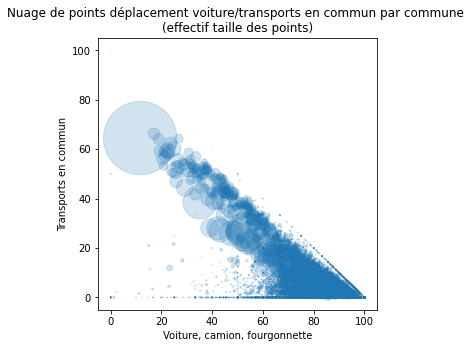

In [19]:
# Construction du tableau croisé pondéré
t, a, p = pyshs.tableau_croise(data_ind, "COMMUNE", "TRANS_reco", "IPONDI", debug=True)

# Graphique avec les pourcentages par commune voiture vs. transports en commun
p.drop("All").plot(
    kind="scatter",
    x="Voiture, camion, fourgonnette",
    y="Transports en commun",
    figsize=(5, 5),
    s=a["All"].drop("All") / 200,
    alpha=0.2,
)
plt.title(
    "Nuage de points déplacement voiture/transports en commun par commune \n(effectif taille des points)"
)
plt.show()

On voudrait analyser un peu plus cette dimension spatiale. Mais avant cela, nous voudrions aussi avoir une variable supplémentaire sur le déplacement des individus pour aller travailler.

### 2.3 Ajout d'une nouvelle dimension : la distance parcourue

Pour cela, on doit passer par les données de localisation de la carte car les données initiales ne contiennent pas de données géographiques.

Il faut donc apparier l'information de la commune de résidence et de travail à une coordonnée géographique. C'est une approximation : nous n'avons pas l'adresse exacte mais uniquement la commune.

- DCLT Département, commune et arrondissement municipal (Paris, Lyon, Marseille) du lieu de travail ;
- COMMUNE Département et commune du lieu de résidence.

Il y a deux manières de calculer des distances :

- en distance à vol d'oiseau de centre de commune à commune ;
- par temps de route utilisant un routeur de parcours.

La première est faisable sans service extérieur ; la seconde nécessite un service de routage, nous montrons un exemple de comment réaliser ce type de traitement mais la généralisation nécessiterait une table de parcours trop massive pour être réalisée dans le cadre de ce Notebook réexécutable.

Nous commençons par dédoublonner la liste des couples ("COMMUNE", "DCLT"), afin de ne pas calculer plusieurs fois la même distance.

In [20]:
dacd_ind = data_ind[["COMMUNE", "DCLT"]].drop_duplicates()

Nous utilisons maintenant le tableau chargé dans la variable `carte` qui est un tableau `Geopandas`, incluant une dimension spatiale, et permettant d'opérer certains calculs spécifiques.

Les données géographiques sont toujours dans une projection particulière. Regardons la projection actuelle de la carte : 

In [21]:
carte["geometry"].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Les données sont des projections GPS ou `EPSG:4326`. Ce format conventionnel est adapté aux traitements que nous souhaitons faire, notamment les calculs de distance. Dans certains cas, nous pourrions être amenés à changer de projection, notamment pour les représentations visuelles de cartes.

Il est possible de calculer le centre de charge zone géographique (commune, correspondant à une surface) avec le paramètre `centroid` de `GeoPandas`.

In [22]:
# Calcul des centres
carte["centres"] = carte["geometry"].centroid

/tmp/ipykernel_12962/1087931078.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  carte["centres"] = carte["geometry"].centroid


In [23]:
# Variables spécifiques de coordonnées
coordonnees = carte.set_index("insee")["centres"]

In [24]:
coordonnees.head()

insee
2B222    POINT (9.33815 42.37429)
2B137    POINT (9.23536 42.37887)
2B051    POINT (9.30211 42.36875)
2B106    POINT (9.26661 42.37556)
2B185    POINT (9.33385 42.64177)
Name: centres, dtype: geometry

Chaque ville est associée à un point (une coordonnée GPS).

On ajoute les coordoonnées associées à la ville de départ, et à la ville d'arrivée en réalisant une *jointure* des deux tableaux sur la clé de la commune. C'est une propriété des tableaux `Pandas` qui relève de la manipulation de bases de données.

In [25]:
dacd_ind = dacd_ind.join(coordonnees, on="COMMUNE", rsuffix="_residence").astype(
    {"COMMUNE": "category"}
)
dacd_ind = dacd_ind.join(coordonnees, on="DCLT", rsuffix="_travail").astype(
    {"DCLT": "category"}
)

In [26]:
dacd_ind.head()

COMMUNE   DCLT                   centres           centres_travail
0    01001  01001  POINT (4.92585 46.15373)  POINT (4.92585 46.15373)
15   01001  01053  POINT (4.92585 46.15373)  POINT (5.24547 46.20492)
22   01001  01093  POINT (4.92585 46.15373)  POINT (4.95797 46.12294)
33   01001  01159  POINT (4.92585 46.15373)  POINT (4.88562 46.33630)
34   01001  01165  POINT (4.92585 46.15373)  POINT (4.81257 46.07364)

Il est maintenant possible de calculer la distance linéaire entre le centre de la ville de départ et celle d'arrivée, en respectant la projection utilisée. Pour cela on définit d'abord une fonction qui le fait pour un individu et on l'applique sur le tableau. Cette opération prend du temps, donc on sauvegarde le calcul une fois effectué.

In [27]:
# Définition d'une fonction qui fait le calcul pour deux points
def distance(point1, point2):
    """Calcule la distance entre deux points.

    Parameters
    ----------
    point1 : geometry
        Coordonnées du premier point
    point2 : geometry
        Coordonnées du second point

    Returns
    -------
    dist_geodes: float
        La distance géodésique entre point1 et point2, en kilomètres.
        Cette distance est 0 si les deux points ont les mêmes coordonnées,
        None si l'un des deux points au moins est indéfini.
    """
    if pd.isnull(point1) or pd.isnull(point2):
        return None
    if point1 == point2:
        return 0
    return geodesic((point1.y, point1.x), (point2.y, point2.x)).kilometers


# Application à l'ensemble des données (environ 6 min 30 sec de calcul)
%time dacd_ind["distance_travail"] = dacd_ind.apply(lambda x: distance(x["centres"], x["centres_travail"]), axis=1)

# Sauvegarde intermédiaire du jeu de données
# pickle.dump(dacd_ind, open(data_interim / "dacd_ind.pkl", "wb"))

CPU times: user 6min 26s, sys: 4.49 s, total: 6min 31s
Wall time: 6min 31s


Si le calcul a déjà été fait, il est possible de charger le fichier de sauvegarde : 

In [28]:
dacd_ind = pickle.load(open(data_interim / "dacd_ind.pkl", "rb"))

Nous pouvons réinjecter ces distances dans la base des déplacements individuels.

In [29]:
data_ind = data_ind.join(
    dacd_ind.set_index(["COMMUNE", "DCLT"]), on=["COMMUNE", "DCLT"]
)

Nous avons donc une nouvelle variable qu'il est possible d'analyser : la distance parcourue. Regardons rapidement sa distribution :

In [30]:
data_ind[data_ind["distance_travail"] < 500]["distance_travail"].hist(bins=40)

<AxesSubplot:>

Il y a quelques outliers (valeurs extrêmes) mais la majorité se trouve dans un rayon de 50 km. C'est une approximation car nous ne considérons que la distance linéaire. Il existe d'autres méthodes que la distance linéaire.

### 2.4 Interroger un service de routage pour la distance parcourue

Plutôt que de calculer la distance directe entre deux communes, il peut être intéressant d'avoir une information sur le temps de route moyen en voiture, qui reste le principal moyen de déplacement.

Le projet OSRM [Open Source Routing Machine](http://project-osrm.org/) propose un accès à leur service avec une API.

Une des options permet de récupérer un tableau de temps de trajets entre des points. On va le mettre en place pour les déplacements d'un département afin de limiter la charge. 

Pour cela il faut créer une liste des points dont on veut les relations. On va le faire pour le département des Bouches-du-Rhône.

In [31]:
points = dict(
    carte[carte["insee"].apply(lambda x: x[0:2] == "13")].set_index("nom")["centres"]
)
points_str = {i: f"{points[i].x},{points[i].y}" for i in points}
print(len(points))

119


Cela représente un peu trop de points, on va donc le limiter sur un sous-ensemble des 10 premiers points, pour ne pas surcharger le service.

In [32]:
# Construction de la requête à partir de la documentation
req = "http://router.project-osrm.org/table/v1/driving/" + (
    ";".join([points_str[i] for i in points_str][0:10])
)

# Exécution de la requête avec Requests
rep = requests.get(req)

# Récupération des données en JSON
rep_json = rep.json()

Les données sont en JSON. Mettons en forme d'un tableau pour mieux les lire.

In [33]:
noms = [i for i in points][0:10]
tableau_temps = pd.DataFrame(rep_json["durations"], columns=noms, index=noms)
tableau_temps

Simiane-Collongue  Aix-en-Provence  \
Simiane-Collongue                     0.0           1466.9   
Aix-en-Provence                    1494.1              0.0   
Le Puy-Sainte-Réparade             2513.4           1554.2   
Marseille                          1831.6           2143.9   
Mollégès                           3741.7           2745.0   
Verquières                         3766.8           2770.1   
Saint-Andiol                       3529.4           2532.7   
Noves                              3996.1           2999.4   
Cabannes                           3545.5           2548.8   
Eygalières                         3895.8           2899.1   

                        Le Puy-Sainte-Réparade  Marseille  Mollégès  \
Simiane-Collongue                       2525.4     1837.7    3778.3   
Aix-en-Provence                         1587.3     2159.5    2705.7   
Le Puy-Sainte-Réparade                     0.0     3178.8    3490.3   
Marseille                               3202.4        0.0    3996.2   
Mollégès                                3480.7     3952.8       0.0   
Verquières                              3505.8     3977.9     492.3   
Saint-Andiol                            3268.4     3740.5     365.6   
Noves                                   3735.1     4207.2     881.7   
Cabannes                                3284.5     3756.6     735.7   
Eygalières                              3634.8     4106.9     473.3   

                        Verquières  Saint-Andiol   Noves  Cabannes  Eygalières  
Simiane-Collongue           3868.0        3577.1  4003.0    3582.1      3939.3  
Aix-en-Provence             2795.4        2504.5  2930.4    2509.5      2866.7  
Le Puy-Sainte-Réparade      3580.0        3289.1  3715.0    3294.1      3626.2  
Marseille                   4085.9        3795.0  4220.9    3800.0      4157.2  
Mollégès                     505.3         363.6   886.6     732.7       472.7  
Verquières                     0.0         312.2   475.4     551.8       937.2  
Saint-Andiol                 322.6           0.0   703.9     456.3       810.5  
Noves                        471.8         701.6     0.0     760.7      1326.6  
Cabannes                     551.7         465.8   766.5       0.0      1143.4  
Eygalières                   945.3         803.6  1326.6    1142.1         0.0

Il est alors possible de calculer la vitesse moyenne entre les villes avec la distance en ligne droite (la réponse temporelle est en secondes).

In [34]:
# On reconstruit un tableau en divisant la distance par le temps
tableau_distance = []
for i in noms:
    ligne = []
    for j in noms:
        ligne.append(
            geodesic((points[i].y, points[i].x), (points[j].y, points[j].x)).kilometers
        )
    tableau_distance.append(ligne)
tableau_distance = pd.DataFrame(tableau_distance, columns=noms, index=noms)
tableau_distance

Simiane-Collongue  Aix-en-Provence  \
Simiane-Collongue                0.000000        14.199030   
Aix-en-Provence                 14.199030         0.000000   
Le Puy-Sainte-Réparade          26.673922        13.250605   
Marseille                       13.317795        27.128069   
Mollégès                        58.875045        46.969295   
Verquières                      63.267259        51.225499   
Saint-Andiol                    60.948486        48.754532   
Noves                           66.016178        53.909610   
Cabannes                        62.941293        50.422234   
Eygalières                      55.266698        43.907659   

                        Le Puy-Sainte-Réparade  Marseille   Mollégès  \
Simiane-Collongue                    26.673922  13.317795  58.875045   
Aix-en-Provence                      13.250605  27.128069  46.969295   
Le Puy-Sainte-Réparade                0.000000  39.941156  43.031384   
Marseille                            39.941156   0.000000  68.455443   
Mollégès                             43.031384  68.455443   0.000000   
Verquières                           46.796129  72.898281   4.443101   
Saint-Andiol                         44.154620  70.777938   2.822272   
Noves                                49.230927  75.666687   7.211257   
Cabannes                             45.069569  73.077120   5.961745   
Eygalières                           41.168342  64.407591   4.785209   

                        Verquières  Saint-Andiol      Noves   Cabannes  \
Simiane-Collongue        63.267259     60.948486  66.016178  62.941293   
Aix-en-Provence          51.225499     48.754532  53.909610  50.422234   
Le Puy-Sainte-Réparade   46.796129     44.154620  49.230927  45.069569   
Marseille                72.898281     70.777938  75.666687  73.077120   
Mollégès                  4.443101      2.822272   7.211257   5.961745   
Verquières                0.000000      2.659625   2.768649   3.840452   
Saint-Andiol              2.659625      0.000000   5.166739   3.163499   
Noves                     2.768649      5.166739   0.000000   4.719161   
Cabannes                  3.840452      3.163499   4.719161   0.000000   
Eygalières                8.903760      7.602844  11.577475  10.709878   

                        Eygalières  
Simiane-Collongue        55.266698  
Aix-en-Provence          43.907659  
Le Puy-Sainte-Réparade   41.168342  
Marseille                64.407591  
Mollégès                  4.785209  
Verquières                8.903760  
Saint-Andiol              7.602844  
Noves                    11.577475  
Cabannes                 10.709878  
Eygalières                0.000000

Il est possible d'avoir plutôt la vitesse en km/h (avec la distance à vol d'oiseau dans ce cas).

In [35]:
tableau_distance / (tableau_temps / (60 * 60))

Simiane-Collongue  Aix-en-Provence  \
Simiane-Collongue                     NaN        34.846621   
Aix-en-Provence                 34.212240              NaN   
Le Puy-Sainte-Réparade          38.205666        30.692432   
Marseille                       26.176054        45.552987   
Mollégès                        56.645419        61.599075   
Verquières                      60.465682        66.572253   
Saint-Andiol                    62.167663        69.300080   
Noves                           59.472546        64.704473   
Cabannes                        63.908801        71.217845   
Eygalières                      51.070412        54.522981   

                        Le Puy-Sainte-Réparade  Marseille   Mollégès  \
Simiane-Collongue                    38.024123  26.089167  56.096701   
Aix-en-Provence                      30.052402  45.223917  62.493795   
Le Puy-Sainte-Réparade                     NaN  45.233472  44.383859   
Marseille                            44.900125        NaN  61.668484   
Mollégès                             44.506273  62.345577        NaN   
Verquières                           48.053529  65.972954  32.490687   
Saint-Andiol                         48.634388  68.119389  27.790423   
Noves                                47.450225  64.746167  29.443717   
Cabannes                             49.398827  70.030781  29.172601   
Eygalières                           40.774192  56.457992  36.397111   

                        Verquières  Saint-Andiol      Noves   Cabannes  \
Simiane-Collongue        58.883695     61.338668  59.370032  63.255815   
Aix-en-Provence          65.969735     70.080381  66.228022  72.333151   
Le Puy-Sainte-Réparade   47.057560     48.328306  47.706955  49.254864   
Marseille                64.229133     67.141127  64.536017  69.230955   
Mollégès                 31.654789     27.943285  29.280989  29.292047   
Verquières                     NaN     30.668323  20.965793  25.055501   
Saint-Andiol             29.679635           NaN  26.424576  24.958572   
Noves                    21.125769     26.511201        NaN  22.333349   
Cabannes                 25.060043     24.449541  22.164356        NaN   
Eygalières               33.908321     34.059530  31.417841  33.758481   

                        Eygalières  
Simiane-Collongue        50.506464  
Aix-en-Provence          55.139210  
Le Puy-Sainte-Réparade   40.870893  
Marseille                55.774879  
Mollégès                 36.443310  
Verquières               34.201383  
Saint-Andiol             33.769573  
Noves                    31.417841  
Cabannes                 33.720099  
Eygalières                     NaN

Il y a des variations importantes, la distance linéaire n'est peut-être pas la meilleure manière de traiter l'information. Une solution pour étendre à l'ensemble de nos données serait de décomposer les requêtes pour couvrir l'ensemble des cas.

## 3. Représenter géographiquement les mobilités

L'objectif est de représenter les mobilités domicile/travail. Deux stratégies peuvent être envisagées : à l'échelle de l'individu, ou à l'échelle de la commune. 

Une représentation à l'échelle de la commune permet de construire une cartographie. Nous allons donc d'abord agréger les informations individuelles à l'échelle de la commune, ce qui revient à calculer la distance moyenne et médiane parcourue par les habitants sur la commune.

In [36]:
distance_commune_moyenne = data_ind.groupby("COMMUNE")["distance_travail"].mean()
distance_commune_mediane = data_ind.groupby("COMMUNE")["distance_travail"].median()

À partir de cela, il est possible de tracer une carte à l'échelle de la commune. Le choix est fait de se concentrer sur la métropole en filtrant les Outre-mer (nous laissons en exercice l'analyse des Outre-mer, suivant la même méthode).

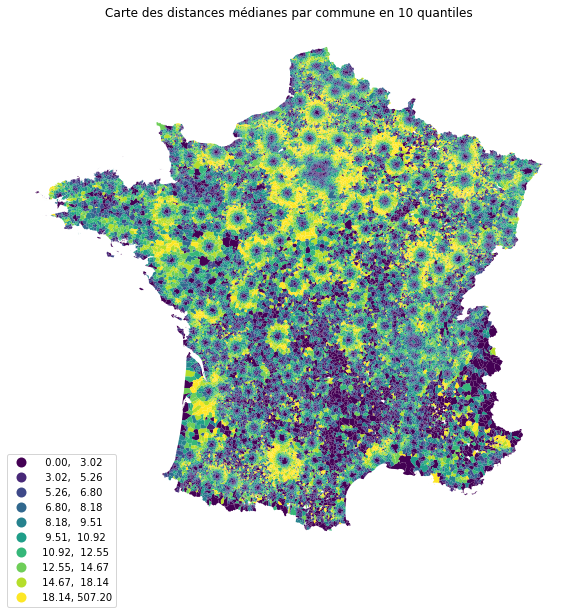

In [37]:
# Construction d'un filtre pour ne prendre qu'une partie des données géographiques
filtre_metropole = carte["insee"].apply(
    lambda x: not (x[0:2] in ["97", "98"] or "A" in x or "B" in x)
)
# Ajout de la colonne distance au tableau géographique et filtre
carte_distances = carte.join(distance_commune_mediane, on="insee")[filtre_metropole]

# Tracer la carte, avec des déciles pour la distance
ax = carte_distances.plot(
    column="distance_travail", legend=True, scheme="quantiles", k=10, figsize=(10, 10)
)

# Mise en forme de la carte
ax.get_legend().set_bbox_to_anchor((0.0, 0.0, 0.2, 0.2))
plt.title("Carte des distances médianes par commune en 10 quantiles")
plt.axis("off")
plt.savefig(
    "../results/carte_distance_mediane_commune.png", bbox_inches="tight", dpi=300
)

Cette carte permet de voir apparaître des régions différenciées de déplacements, largement structurées par les pôles attracteurs urbains. En effet, en contrastant les couleurs par déciles (donc en regroupant d'une même couleur des villes ayant des profils similaires), elle permet de mieux faire apparaître l'homogénéité de certaines zones.

Il est aussi possible de zoomer sur certains départements. La limite est alors la granularité des communes.

In [38]:
# On définit un autre filtre
filtre13 = carte["insee"].apply(lambda x: x[0:2] == "13")

# Sélection de la carte
carte_distances = carte.join(distance_commune_mediane, on="insee")[filtre13]

# Visualisation
carte_distances.plot(
    column="distance_travail", legend=True, scheme="quantiles", k=10, figsize=(10, 10)
)
plt.title("Carte des distances médianes par commune en 10 quantiles pour le 13")
plt.axis("off")
plt.show()

Nous vous laissons explorer d'autres zones d'intérêt. Comment passer d'une caractérisation par commune à une analyse des structures que nous observons ? Nous voudrions construire des profils de communes.

## 4. Étudier les profils des communes

Les comportements de déplacements sont différents suivant les communes. Il est possible de se demander quelle part de cette pratique dépend de la commune et quelle part dépend des habitants.

Pour cela, nous allons aussi utiliser les données INSEE à l'échelle de la commune, plus adaptée à ce niveau d'analyse. Nous allons essayer de construire des classifications.

Nous pouvons décrire les communes par une diversité de caractéristiques populationnelles (profil de la population, etc.). Cependant le nombre de communes est important et nous voudrions réduire les dimensions. Une première stratégie est d'utiliser une analyse factorielle (identifier les principales dimensions structurantes des données) puis une classification en K-Means à partir de ces dimensions.

Nous utilisons uniquement une partie des dimensions correspondant au recensement de 2019 (préfixe `P18_`), nous retirons les questions spécifiques aux mobilités qui sont incorporées pour construire une caractérisation uniquement sur le profil des villes, et nous normalisons en proportion du nombre d'habitants toutes les variables données en valeurs absolues.

Comme ce sont des données qui ne sont pas "parfaites", nous allons réaliser plusieurs opérations:
* enlever les colonnes ayant trop de valeurs nulles ;
* ne garder que les variables du recensement de 2019 ;
* enlever les variables spécifiques sur la voiture, car c'est ce que nous voulons étudier ;
* ajouter une nouvelle information ;
* normaliser par rapport au nombre d'habitants de la commune ;
* supprimer des lignes avec des valeurs manquantes.

In [39]:
# Enlever les colonnes qui ont trop de valeurs nulles
var_nulles = pd.isnull(data_com).sum() > 10000
var_nulles = var_nulles[var_nulles].index

# Toutes les variables du sondage de 2019
var_19_communes = list(meta_com[meta_com["COD_VAR"].str.contains("P19_")]["COD_VAR"])

# Enlever les items mobilités et portant sur la possession de voiture
var_19_communes = [
    i
    for i in var_19_communes
    if not "ACTOCC15P" in i and not "P19_RP_VOIT" in i and not i in var_nulles
]

# Tableau de description des communes
description_communes = data_com.set_index("CODGEO")[var_19_communes]

# Ajout de la superficie aux données à partir des informations de la carte
description_communes = description_communes.join(carte.set_index("insee")["surf_ha"])

# Normalisation par la population du tableau de données pour avoir des densités par habitants
description_communes = pd.concat(
    [
        description_communes.apply(
            lambda l: l[var_19_communes[1:]] / l["P19_POP"]
            if pd.notnull(l["P19_POP"])
            else None,
            axis=1,
        ),
        description_communes["P19_POP"],
    ],
    axis=1,
)

# Enlever les lignes ayant des valeurs nulles
description_communes = description_communes.dropna()

description_communes.shape

(34864, 338)

Il serait possible d'explorer les différentes formes de normalisation pour voir si cela a des conséquences sur les résultats ultérieurs (ce traitement n'est pas réalisé dans ce notebook).

Dans notre cas, les données sont numériques. L'analyse factorielle est donc une Analyse en Composantes Principales (ACP). Ensuite, à partir des principaux axes qui résument l'information, nous pourrons réaliser une classification avec la méthode des K-Means.

La première étape est donc de projeter le tableau dans un espace de dimension inférieure avec une analyse en composantes principales (ACP).

In [40]:
# Définition de la projection et projection
projection = prince.PCA(n_components=7)
projection = projection.fit(description_communes)

# Tableau projeté
Xt = projection.row_coordinates(description_communes)

Nous pouvons regarder le poids de chaque axe (total valant 1) :

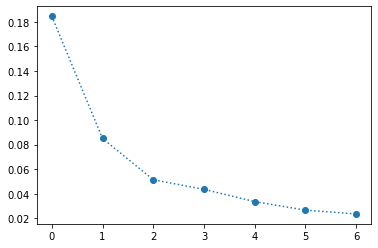

In [41]:
plt.plot(projection.explained_inertia_, "o:")

Il est aussi intéressant de regarder les corrélations entre les variables pour leur donner du sens.

In [42]:
correlations = projection.column_correlations(description_communes).sort_values(0)
correlations.head()

0         1         2         3         4         5  \
P19_POP2554    -0.838279 -0.119244  0.122889 -0.108364  0.289105  0.008049   
P19_ACT2554    -0.836261 -0.239495  0.154809 -0.135308  0.232372  0.035988   
P19_ACTOCC2554 -0.811763 -0.345673  0.184044 -0.133629  0.114916  0.022429   
P19_SAL15P     -0.810869 -0.175322  0.284903  0.083890 -0.080499  0.333620   
P19_F2554      -0.801320 -0.059599  0.093891 -0.175203  0.073557  0.088149   

                       6  
P19_POP2554    -0.030935  
P19_ACT2554    -0.096562  
P19_ACTOCC2554 -0.229725  
P19_SAL15P     -0.166337  
P19_F2554       0.074796

La lecture graphique se fait généralement avec une figure, le cercle des corrélations. Or, il n'est pas possible d'obtenir directement le cercle de corrélation avec les bibliothèques existantes (contrairement par exemple aux bibliothèques en R). Avec quelques lignes, il est cependant possible de le construire comme on le souhaite, notamment en affichant uniquement les corrélations les plus importantes pour ne pas surcharger le schéma.

(Cela vaut pour tout autre traitement : si celui-ci n'est pas disponible, il y a toujours une possibilité de le faire soi-même, puis ensuite de partager son code).

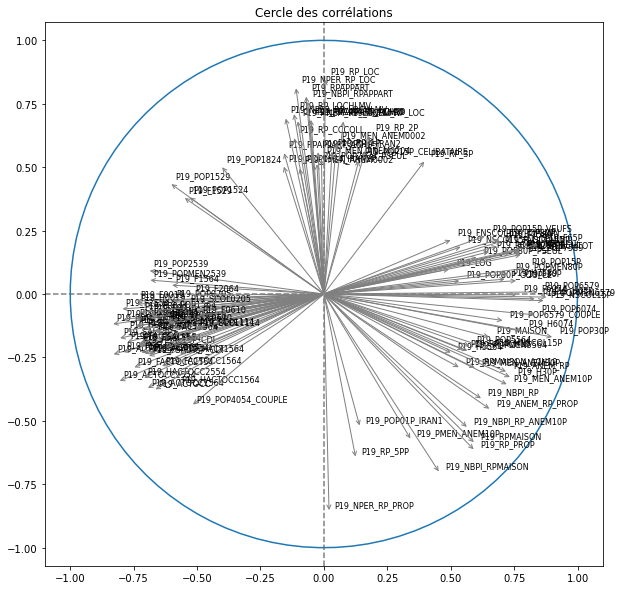

In [43]:
# seuil de corrélation limite pour représenter
seuil_corr = 0.5

# Définir une nouvelle figure
fig, ax = plt.subplots(figsize=(10, 10))

# Parcourir chaque variable
for i, j in correlations.iterrows():

    # Si le seuil est dépassé pour l'une des dimensions
    if abs(j[0]) >= seuil_corr or abs(j[1]) >= seuil_corr:

        # Ajouter la flèche et l'annotation correspondante
        ax.annotate(
            "",
            xy=(j[0], j[1]),
            xytext=(0, 0),
            arrowprops={"arrowstyle": "->", "color": "gray"},
        )
        ax.annotate(i, (j[0] + 0.02, j[1] + 0.02), size=8)

# Mettre en forme la figure avec le cercle
ax.set_title("Cercle des corrélations")
ax.axhline(y=0, color="grey", linestyle="--")
ax.axvline(x=0, color="grey", linestyle="--")
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis("equal")
plt.show()

La lecture des variables n'est pas très aisée, il est possible de faire varier le seuil d'affichage des corrélations et de revenir aux intitulés des questions.

In [44]:
description("P19_RP_LOC", meta_com)

'Rés princ occupées Locataires en 2019 (princ)'

On renomme les axes, notamment le premier pour le conserver par la suite comme un indicateur à part entière. En effet, une pratique courante pour construire un indicateur unidimensionnel est de conserver le premier axe d'une ACP sur un grand jeu de données. Dans notre cas, le premier axe de l'ACP représente près de 20% de la variance.

In [45]:
Xt = Xt.rename(columns={i: f"ACP_{i}" for i in Xt.columns})
carte = carte.join(Xt["ACP_0"], on="insee")

Il est aussi possible d'utiliser l'ensemble des dimensions pour ensuite procéder à une classification. Pour cela, nous calculons des regroupements (clusters) avec la méthode des K-Means. La question se pose toujours du nombre de clusters à garder (il existe différentes stratégies). 

Représentons la variance inter-groupes pour différents nombres de groupes : 

In [ ]:
inerties = []

# Boucle sur le nombre de groupes
K = range(1, 20)
for k in K:
    # Classification pour ce nombre
    km = KMeans(n_clusters=k)
    km = km.fit(Xt)
    inerties.append(km.inertia_)

# Affichage de la courbe
plt.plot(K, inerties, "bx-")
plt.xlabel("k")
plt.ylabel("Somme des distances au carrée")
plt.title('Méthode dite du "coude"')
plt.show()

On choisit de garder 5 clusters, nous refaisons donc une classification avec ce paramètre.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(Xt)

Et nous rajoutons une colonne associant le cluster à la ligne, puis nous construisons la carte correspondante.

In [48]:
description_communes["categorie"] = kmeans.labels_
carte = carte.join(description_communes["categorie"].apply(str), on="insee")

Il est alors possible de représenter ces deux méthodes de classification : en continu avec le premier axe de l'ACP (qui représente la principale dimension de variabilité de nos données) et en catégorie avec les clusters.

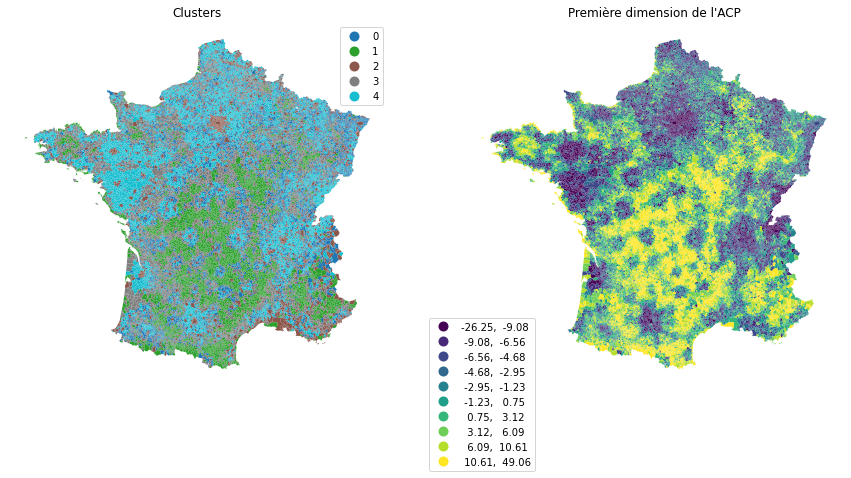

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# Première carte
carte[filtre_metropole].plot(column="categorie", legend=True, k=10, ax=ax[0])

# Deuxième carte
carte[filtre_metropole].plot(
    column="ACP_0", legend=True, ax=ax[1], scheme="quantiles", k=10
)

ax[0].set_title("Clusters")
ax[0].axis("off")

ax[1].set_title("Première dimension de l'ACP")
ax[1].axis("off")

# Déplacement de la légende
leg = ax[1].get_legend()
leg.set_bbox_to_anchor((0.0, 0.0, 0.2, 0.2))

Cette carte prend en compte toutes les dimensions : sociales, mais aussi les trajets domicile-travail. Sans surprise, il y a une correspondance générale entre ces deux indicateurs. Suivant les usages et les modèles à faire ensuite, l'une ou l'autre des représentations peut être privilégiée.

## 5. Regrouper les communes par proximité de déplacement

La typologie produite précédemment considère chaque commune indépendamment. Comme nous avons des données sur les déplacements professionnels, il est aussi possible de regrouper les communes par proximité d'usage entre résidence/travail.

Pour cela, nous allons utiliser une stratégie qui s'appuie sur l'analyse de réseaux.

### 5.1 Construire le réseau des trajets

L'idée est de construire le réseau des liens entre la ville de résidence et la ville de travail. Les nœuds sont donc des villes ; le lien est l'existence d'un trajet professionnel. Chaque ville est définie par le nombre d'actifs.

On va donc construire un réseau en itérant sur le tableau et en augmentant de 1 la pondération de la ville de résidence et de 1 le lien entre les deux villes concernées. Pour des raisons de simplicité, nous utilisons un réseau non-orienté : un lien existe entre deux villes si un individu habite dans l'une et va travailler dans l'autre (il est évidemment possible de refaire cette analyse avec un réseau orienté dans la mesure où les flux sont orientés, du domicile vers le travail par exemple).

Pour cela, nous utilisons la bibliothèque `networkx`. La construction du réseau prend un peu de temps car on itère sur les millions de lignes.

In [50]:
# les nœuds seront les communes de domicile, pondérées par leur nombre d'actifs résidents
nodes = [
    (k, {"label": k, "poids": v})
    for k, v in data_ind["COMMUNE"].value_counts().to_dict().items()
]
# ... ainsi que les communes destination manquantes (car elles ne sont pas des communes sources), avec un poids de 1
nodes.extend(
    [
        (k, {"label": k, "poids": 1})
        for k in set(data_ind["DCLT"].unique()) - set(data_ind["COMMUNE"].unique())
    ]
)

# les liens seront les couples de villes domicile-travail, pondérés par le nombre de déplacements entre elles ;
# attention, ici les couples sont encore orientés ((A, B) != (B, A)), leur ajout dans un graphe non-orienté y remédiera
edges = [
    (src, tgt, v)
    for (src, tgt), v in data_ind[["COMMUNE", "DCLT"]].value_counts().to_dict().items()
]

# on crée le graphe vide
reseau = nx.Graph()
# on ajoute les nœuds
reseau.add_nodes_from(nodes)
# on ajoute les liens, en additionnant les poids des paires (A, B) et (B, A)
reseau.add_weighted_edges_from(edges, weight="poids")

On a donc un réseau qui a les propriétés suivantes :

In [51]:
print("Nombre de noeuds : ", len(reseau.nodes))
print("Nombre de liens : ", len(reseau.edges))

Nombre de noeuds :  35355
Nombre de liens :  782844


Une fois le réseau construit, il est souhaitable de le sauvegarder (pour le charger, mais aussi pour éventuellement l'ouvrir avec un logiciel tiers comme Gephi : https://gephi.org/)

In [ ]:
nx.write_graphml(reseau, data_interim / "reseau_circulation_pro_villes.graphml")

### 5.2 Visualiser un réseau

La visualisation de réseau demande des ressources de calculs et nécessite de nombreux paramétrages. 

Pour cette raison il est difficile de visualisation l'ensemble du réseau et il est préférable de visualiser des éléments précis, par exemple l'égo-graph centré sur une ville à un certain diamètre (1, ou 2).

In [54]:
sous_reseau = nx.ego_graph(reseau, "69381", 1)

Utilisation de bibliothèque `Networkx` pour la visualisation : il faut d'abord préparer les valeurs à représenter (en définissant l'échelle que l'on souhaite, souvent par essai/erreur) puis les tracer.

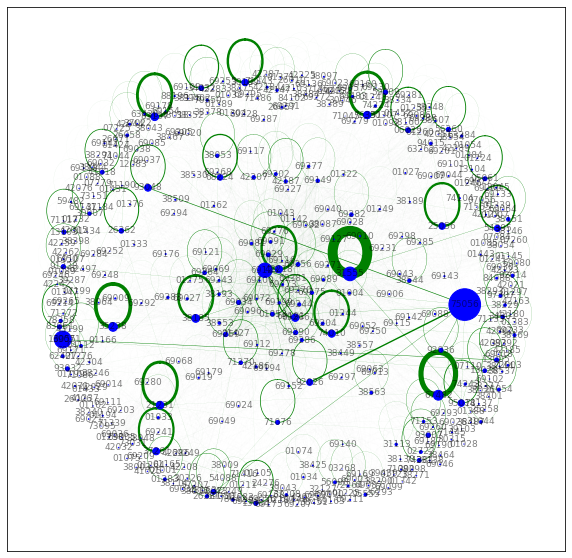

In [55]:
# Liste du poids des liens et normalisation
poids_liens = [sous_reseau[u][v]["poids"] for u, v in sous_reseau.edges()]
poids_liens = [i*10/max(poids_liens) for i in poids_liens]

# Liste du poids des noeuds et normalisation
poids_noeuds = [sous_reseau.nodes(data="poids")[u]for u, v in sous_reseau.nodes(data="poids")]
poids_noeuds = [i*1000/max(poids_noeuds) for i in poids_noeuds]

# Spatialisation des points avec un algorithme "ressort"
positions = nx.spring_layout(sous_reseau,k=2)

# Créer une figure
fig,ax = plt.subplots(figsize=(10,10))

# Tracer les noeuds, puis les liens, puis les labels avec différentes options
nx.draw_networkx_nodes(sous_reseau, positions, node_size=poids_noeuds, node_color="blue", ax=ax)
nx.draw_networkx_edges(sous_reseau, positions, edge_color="green", ax=ax,width=poids_liens)
nx.draw_networkx_labels(sous_reseau, pos=positions, ax=ax, font_size=9,alpha=0.5)
plt.show()

Les boucles représentent les trajets intracommunaux. La proximité des communes est liées à la force des liens entre elles (trajets). La taille des noeuds correspond au nombre de personnes dans la commune (par. ex la région parisienne est très importante en taille, mais peu connectée à la commune étudiée ici). 

L'analyse de réseaux de manière dynamique est très facile sous un logiciel dédié comme Gephi. Il existe des possibilités de manipuler des réseaux de manière interactive directement en Python, notamment avec la bibliothèque  `Pyvis`. Cependant, outre qu'elle est peu adaptée pour de très grands réseaux, son exécution sur le serveur n'est pas optimisée. Il est possible de l'utiliser lors d'une exécution locale. 

Exemple de code : 

```` python
from pyvis import network

visu = network.Network(notebook=True)
visu.from_nx(sous_reseau)
visu.show("reseau.html")
````

### 5.3 Clusters dans un réseau

Il existe différentes stratégies spécifiques pour trouver des clusters dans un réseau tenant compte de la structure de ce réseau. Un des algorithmes les plus utilisés est la détection de modularité Louvain. Pour plus d'information : <https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html>

In [56]:
import networkx.algorithms.community as nx_comm

# Identification des clusters
seuil = 1  # Définition d'un seuil (qui détermine le nombre de clusters)
clusters = nx_comm.louvain_communities(
    reseau, seed=123, weight="poids", threshold=seuil
)

print(f"Il y a {len(clusters)} clusters")

Il y a 385 clusters


Il est possible d'explorer l'espace des paramètres du seuil pour augmenter/diminuer le nombre de regroupements.

### 5.4 Carte des zones

Remettons les données en forme pour les afficher sur une carte, car le format à la sortie de la classification n'est pas directement sous la forme d'un tableau.

In [57]:
attribution = []
for i in range(0, len(clusters)):
    for j in clusters[i]:
        attribution.append([i, j])
attribution = pd.DataFrame(attribution, columns=["cluster", "insee"]).set_index("insee")

Il ne reste plus qu'à afficher la carte (attention, les couleurs sont générées automatiquement, et il est possible que certaines  zones adjacentes aient la même couleur par hasard ... une analyse plus fine serait nécessaire pour établir des résultats définitifs.)

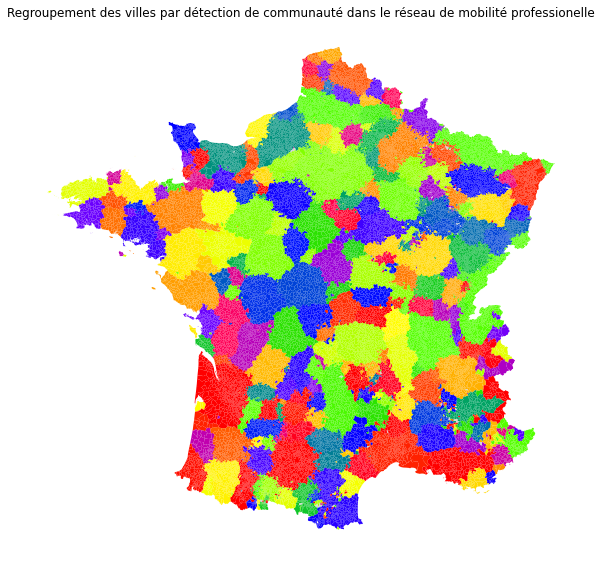

In [58]:
# Ajouter la variable à représenter
carte_clusters = carte.join(attribution, on="insee")[filtre_metropole]

# Afficher la carte
carte_clusters.plot(
    column="cluster",
    legend=False,
    figsize=(10, 10),
    missing_kwds=dict(
        color="lightgrey",
    ),
    cmap="prism",
)

# Titre et mise en forme
plt.title(
    "Regroupement des villes par détection de communauté dans le réseau de mobilité professionelle"
)
plt.axis("off")
plt.show()

## 6. Utiliser la catégorie spatiale dans un modèle statistique

Pour la dernière étape dans ce Notebook, nous voudrions prédire la proportion de possesseurs de voiture dans une ville. Certainement, cela sera en lien avec la proportion d'actifs. Mais il est possible aussi que ce soit en lien avec la situation spatiale de la ville. Pour cela, un modèle spatial pourrait être pertinent.

La variable d'intérêt est `P19_RP_VOIT1P`. Nous allons la normaliser par rapport au nombre d'habitants de la commune.

### 6.1 Analyse descriptive

Comme à chaque fois, la première étape est de regarder la variable d'intérêt.

In [59]:
description("P19_RP_VOIT1P", meta_com)

'Ménages au moins une voiture en 2019 (princ)'

Nombre de valeurs nulles 39


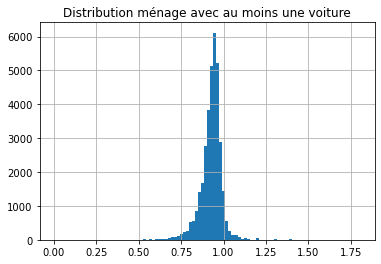

In [60]:
# Définir une fonction qui calcule une proportion (ou renvoie rien si pas possible)
def proportion(x):
    if pd.isnull(x["P19_RP_VOIT1P"]) or pd.isnull(x["C19_MEN"]) or x["C19_MEN"] == 0:
        return None
    return x["P19_RP_VOIT1P"] / x["C19_MEN"]


# Appliquer le calcul
data_com["prop_menage_voiture"] = data_com[["P19_RP_VOIT1P", "C19_MEN"]].apply(
    proportion, axis=1
)

print("Nombre de valeurs nulles", pd.isnull(data_com["prop_menage_voiture"]).sum())
data_com["prop_menage_voiture"].hist(bins=100)
plt.title("Distribution ménage avec au moins une voiture")
plt.show()

Cette courbe représente par ville la proportion de foyers (entre 0 et 1) ayant une voiture. 

Il semble y avoir des erreurs dans les données, car on trouve une proportion supérieure à 1. Une investigation serait nécessaire pour comprendre cette différence. 

Représentons à l'échelle nationale cette distribution.

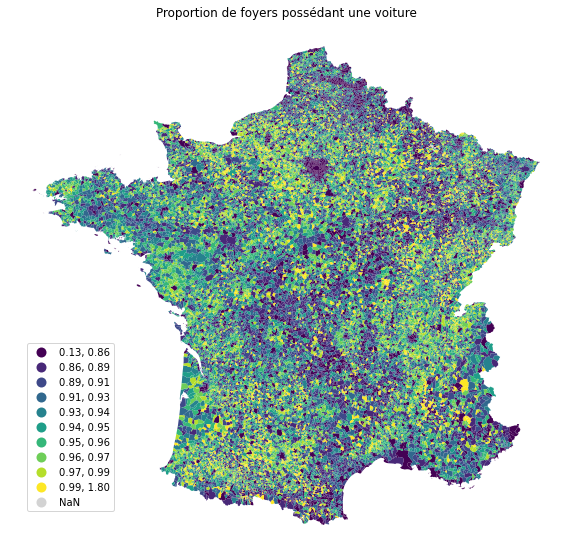

In [61]:
ax = (
    carte[filtre_metropole]
    .join(data_com.set_index("CODGEO")["prop_menage_voiture"], on="insee")
    .plot(
        column="prop_menage_voiture",
        figsize=(10, 10),
        legend=True,
        missing_kwds=dict(
            color="lightgrey",
        ),
        cmap="viridis",
        scheme="quantiles",
        k=10,
    )
)
ax.get_legend().set_bbox_to_anchor((0.0, 0.2, 0.2, 0.2))
plt.title("Proportion de foyers possédant une voiture")
plt.axis("off")
plt.show()

Pour tenir compte de l'information du nombre d'habitants par commune, il est intéressant d'utiliser une autre forme de représentation : une anamorphose. Il suffit de garder les mêmes données mais de changer de fond de carte.

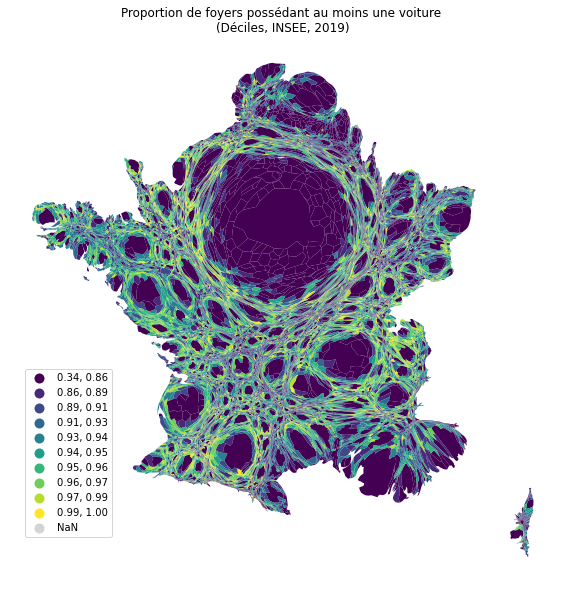

In [62]:
# Nous corrigeons les données pour les proportions supérieures à 100%
data_com["prop_menage_voiture"] = data_com["prop_menage_voiture"].apply(
    lambda x: 1 if x > 1 else x
)

# Tracer la carte
ax = carte_ana.join(
    data_com.set_index("CODGEO")["prop_menage_voiture"], on="INSEE_COM"
).plot(
    column="prop_menage_voiture",
    figsize=(10, 10),
    legend=True,
    missing_kwds=dict(
        color="lightgrey",
    ),
    cmap="viridis",
    scheme="quantiles",
    k=10,
)

# Mise en forme de la varte
ax.get_legend().set_bbox_to_anchor((0.0, 0.2, 0.2, 0.2))
plt.title(
    "Proportion de foyers possédant au moins une voiture \n(Déciles, INSEE, 2019)"
)
plt.axis("off")
plt.show()

Sans trop de surprises, les zones très denses (donc qui apparaissent dans l'anamorphoses) sont celles avec le taux plus bas d'équipement en voiture, correspondant aux zones fortement urbanisées.

L'idée serait maintenant de modéliser au mieux cette proportion de ménages ayant une voiture. On peut utiliser un modèle linéaire pour modéliser la proportion en fonction de tous les autres paramètres.

Pour une logique plus prédictive que descriptive, on peut utiliser toutes les variables en partie corrélées. Donc on sélectionne les variables corrélées au-dessus d'un seuil, et on construit un modèle.

### 6.2 Modèle linéaire multivarié

Un modèle linéaire multivarié vise à construire une relation entre une variable dépendante et la somme des variables indépendantes 

$$Y = a_1*X_1 + ... + a_n * X_n + C + \epsilon$$

In [63]:
# Construire le tableau avec toutes les variables
tableau = description_communes.join(data_com.set_index("CODGEO")["prop_menage_voiture"])

# Faire une boucle pour garder uniquement les variables corrélées à un seuil
var_corr = []
seuil = 0.3
for i in var_19_communes:
    cor = tableau[[i, "prop_menage_voiture"]].corr().iloc[1, 0]
    if abs(cor) > seuil:
        var_corr.append([i, description(i, meta_com), cor])

# Afficher le tableau
pd.DataFrame(var_corr, columns=["variable", "descriptif", "corrélation"]).sort_values(
    "corrélation"
).set_index("variable")

descriptif  \
variable                                                                    
P19_RP_LOC                  Rés princ occupées Locataires en 2019 (princ)   
P19_ANEM_RP_LOC         Anc tot Emméngt Rés princ occ par Locataires (...   
P19_RPAPPART                   Rés princ type appartement en 2019 (princ)   
P19_RPAPPART_ACH70      Rés princ Type appart 1946 à 1970 en 2019 (princ)   
P19_ANEM_RP_LOCHLMV     Anc tot Emméngt Rés princ HLM louées vides (an...   
P19_NBPI_RPAPPART       Pièces rés princ type appartement en 2019 (princ)   
P19_NPER_RP_LOC         Pers Rés princ occupées Locataires en 2019 (pr...   
P19_RP_LOCHLMV                   Rés princ HLM louée vide en 2019 (princ)   
P19_NPER_RP_LOCHLMV       Pers Rés princ HLM louées vides en 2019 (princ)   
P19_RP_2P                              Rés princ 2 pièces en 2019 (princ)   
P19_RP_CCCOLL           Rés princ Chauffage Central Collectif  en 2019...   
P19_RP_1P                               Rés princ 1 pièce en 2019 (princ)   
P19_RPAPPART_ACH90      Rés princ Type appart 1971 à 1990 en 2019 (princ)   
P19_RPAPPART_ACH45      Rés princ Type appart 1919 à 1945 en 2019 (princ)   
P19_RP_ACH70                        Rés princ 1946 à 1970 en 2019 (princ)   
P19_RP_3P                              Rés princ 3 pièces en 2019 (princ)   
P19_POP15P_CELIBATAIRE     Pop 15 ans ou plus célibataire en 2019 (princ)   
P19_POP80P_PSEUL          Pop 80 ans ou plus vivant seule en 2019 (princ)   
P19_POP15P_VEUFS        Pop 15 ans ou plus veuves ou veufs en 2019 (pr...   
P19_FNSCOL15P_DIPLMIN   Femmes 15 ans ou plus non scol. Sans diplôme o...   
P19_RPAPPART_ACH19         Rés princ Type appart avt 1919 en 2019 (princ)   
P19_NSCOL15P_DIPLMIN    Pop 15 ans ou plus non scol. Sans diplôme ou C...   
P19_RP_ACHTOT                          Rés princ avt 2016 en 2019 (princ)   
P19_F7589                            Pop Femmes 75-89 ans en 2019 (princ)   
P19_POP2024_PSEUL              Pop 20-24 ans vivant seule en 2019 (princ)   
P19_RP                             Résidences principales en 2019 (princ)   
P19_MEN                                           Ménages en 2019 (princ)   
P19_POP80P                             Pop 80 ans ou plus en 2019 (princ)   
P19_POP01P_IRAN2        Pop 1 an ou plus habitant 1 an avt autre logt ...   
P19_POP2539_PSEUL              Pop 25-39 ans vivant seule en 2019 (princ)   
P19_RPMAISON_ACH15      Rés princ Type maison 2006 à 2015 en 2019 (princ)   
P19_RPMAISON_ACH05      Rés princ Type maison 1991 à 2005 en 2019 (princ)   
P19_FACTOCC1564           Actifs occupés 15-64 ans Femmes en 2019 (princ)   
P19_FACTOCC2554           Actifs occupés 25-54 ans Femmes en 2019 (princ)   
P19_NBPI_RPMAISON            Pièces rés princ type maison en 2019 (princ)   
P19_ACTOCC2554                   Actifs occupés 25-54 ans en 2019 (princ)   
P19_ACTOCC                                 Actifs occupés en 2019 (princ)   
P19_ACTOCC1564                   Actifs occupés 15-64 ans en 2019 (princ)   
P19_RP_5PP                     Rés princ 5 pièces ou plus en 2019 (princ)   
P19_POP4054_COUPLE         Pop 40-54 ans vivant en couple en 2019 (princ)   
P19_NPER_RP_PROP        Pers Rés princ occupées Propriétaires en 2019 ...   

                        corrélation  
variable                             
P19_RP_LOC                -0.528348  
P19_ANEM_RP_LOC           -0.523477  
P19_RPAPPART              -0.513457  
P19_RPAPPART_ACH70        -0.499444  
P19_ANEM_RP_LOCHLMV       -0.496544  
P19_NBPI_RPAPPART         -0.496120  
P19_NPER_RP_LOC           -0.483806  
P19_RP_LOCHLMV            -0.477110  
P19_NPER_RP_LOCHLMV       -0.462508  
P19_RP_2P                 -0.462022  
P19_RP_CCCOLL             -0.455119  
P19_RP_1P                 -0.450050  
P19_RPAPPART_ACH90        -0.440172  
P19_RPAPPART_ACH45        -0.426966  
P19_RP_ACH70              -0.410020  
P19_RP_3P                 -0.402136  
P19_POP15P_CELIBATAIRE    -0.368436  
P19_POP80P_PSEUL          -0.

On peut maintenant construire un modèle. 

Attention, il y a des valeurs nulles; dans notre cas, nous allons simplement les enlever. 

(Par rapport à `scikit-learn`, `statsmodels` donne des résumés plus interprétables.)

In [64]:
import statsmodels.api as sm

# filtre des valeurs non nulles
na = pd.notna(tableau["prop_menage_voiture"])

# construction des tableaux pour le modèle
Y = tableau[na]["prop_menage_voiture"]
X = tableau[na][[i[0] for i in var_corr]]

# Il faut ajouter une constante pour avoir le modèle
Xm = sm.add_constant(X)

# Construction du modèle et calcul du score
reg = sm.OLS(Y, Xm).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     prop_menage_voiture   R-squared:                       0.535
Model:                             OLS   Adj. R-squared:                  0.534
Method:                  Least Squares   F-statistic:                     999.8
Date:                 Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                         13:09:31   Log-Likelihood:                 62348.
No. Observations:                34858   AIC:                        -1.246e+05
Df Residuals:                    34817   BIC:                        -1.243e+05
Df Model:                           40                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.0042      0.008    131.108      0.000       0.989       1.019
P19_F7589                 -0.0661      0.019     -3.392      0.001      -0.104      -0.028
P19_POP01P_IRAN2          -0.1075      0.015     -7.185      0.000      -0.137      -0.078
P19_POP80P                 0.1472      0.014     10.388      0.000       0.119       0.175
P19_POP2024_PSEUL         -0.2550      0.056     -4.566      0.000      -0.364      -0.146
P19_POP2539_PSEUL         -0.0546      0.028     -1.975      0.048      -0.109      -0.000
P19_POP80P_PSEUL          -0.6961      0.022    -31.542      0.000      -0.739      -0.653
P19_POP4054_COUPLE         0.0155      0.009      1.802      0.072      -0.001       0.032
P19_POP15P_VEUFS          -0.1971      0.014    -14.008      0.000      -0.225      -0.170
P19_POP15P_CELIBATAIRE    -0.1016      0.007    -15.238      0.000      -0.115      -0.088
P19_RP                     0.0598      0.014      4.403      0.000       0.033       0.086
P19_RP_1P                 -0.6934      0.038    -18.442      0.000      -0.767      -0.620
P19_RP_2P                 -0.1133      0.021     -5.416      0.000      -0.154      -0.072
P19_RP_3P                  0.0013      0.014      0.097      0.923      -0.026       0.028
P19_RP_5PP                -0.0041      0.013     -0.318      0.750      -0.029       0.021
P19_NBPI_RPMAISON          0.0040      0.004      0.992      0.321      -0.004       0.012
P19_RPAPPART              -0.4269      0.038    -11.133      0.000      -0.502      -0.352
P19_NBPI_RPAPPART          0.1719      0.012     13.999      0.000       0.148       0.196
P19_RP_ACHTOT             -0.0702      0.021     -3.351      0.001      -0.111      -0.029
P19_RP_ACH70              -0.0601      0.009     -6.835      0.000      -0.077      -0.043
P19_RPMAISON_ACH05         0.1245      0.009     13.629      0.000       0.107       0.142
P19_RPMAISON_ACH15         0.0127      0.010      1.270      0.204      -0.007       0.032
P19_RPAPPART_ACH19        -0.5385      0.023    -23.552      0.000      -0.583      -0.494
P19_RPAPPART_ACH45        -1.0085      0.039    -25.586      0.000      -1.086      -0.931
P19_RPAPPART_ACH70        -0.2436      0.028     -8.607      0.000      -0.299      -0.188
P19_RPAPPART_ACH90         0.0662      0.026      2.588      0.010       0.016       0.116
P19_MEN                    0.0598      0.014      4.403      0.000       0.033       0.086
P19_RP_LOC                 0.1860      0.024      7.706      0.000       0.139       0.233
P19_RP_LOCHLMV             0.2302      0.055      4.218      0.000       0.123       0.337
P19_NPER_RP_PROP          -0.0524      0.007     -7.197      0.000      -0.067      -0.038
P19_NPER_RP_LOC           -0.1454      0.011    -13.032      0.000   

Notre modèle a un $R^2$ de 0.45. Est-ce qu'on peut l'améliorer avec des variables spatiales ?

### 6.3 Régression spatiale

Il est possible d'intégrer l'information spatiale dans certaines régressions. Ce sont des algorithmes spécifiques développés pour la géographie, et nous présentons un usage à titre d'exemple.

Pour construire une régression spatiale, il existe une bibliothèque dédiée `Pysal`.

(pour un tutorial plus long : <https://geographicdata.science/book/notebooks/11_regression.html> )

In [65]:
import pysal as ps
import libpysal
from libpysal.weights import Queen, Rook, KNN
from spreg import OLS

Nous construisons le modèle : pour cela, il faut définir proprement les variables en supprimant les valeurs manquantes et en associant avec l'information géographique. Il existe différentes stratégies de spatialisation, dans ce cas nous choisissons la plus rapide : un K-Mean sur les centres.

In [66]:
# Construction d'un tableau
tableau = description_communes.join(data_com.set_index("CODGEO")["prop_menage_voiture"])
# Ajout de l'information géographique
tableau = tableau.join(
    carte[filtre_metropole].set_index("insee")[["centres", "geometry"]]
)
# Suppression des valeurs manquantes
tableau = tableau.dropna()
# Définition des variables
X = tableau[[i[0] for i in var_corr]]  # uniquement les variables corrélées
Y = tableau[["prop_menage_voiture"]]

# Pondération spatiale avec un KMEAN
w = KNN.from_dataframe(tableau, geom_col="centres", k=10).to_file("temp.gal")
w = libpysal.io.open("./temp.gal").read()
w.transform = "r"

# Construction du modèle spatial en assurant que les tableaux sont au bon format
m = OLS(
    Y.values,
    X.values,
    w=w,
    spat_diag=True,
    name_x=list(X.columns),
    name_y="prop_menage_voiture",
)
print(m.summary)

/home/eschultz/.local/lib/python3.8/site-packages/spreg/diagnostics.py:331: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/home/eschultz/.local/lib/python3.8/site-packages/spreg/diagnostics.py:147: RuntimeWarning: invalid value encountered in sqrt
  tStat = betas[list(range(0, len(vm)))].reshape(len(vm),) / np.sqrt(variance)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :prop_menage_voiture                Number of Observations:       34453
Mean dependent var  :      0.9274                Number of Variables   :          42
S.D. dependent var  :      0.0565                Degrees of Freedom    :       34411
R-squared           :-274135961425431465362980864.0000
Adjusted R-squared  :-274462588795122611570868224.0000
Sum squared residual:30178985398979033736562081792.000                F-statistic           :    839.2927
Sigma-square        :877015646129988428627968.000                Prob(F-statistic)     :           0
S.E. of regression  :936491135104.860                Log likelihood        : -998576.606
Sigma-square ML     :875946518415784810643456.000                Akaike info criterion : 1997237.211
S.E of regression ML:935920145319.9866                Sch

La régression confirme la dépendance spatiale de la pratique des mobilités (les différents tests sont significatifs). Il est possible d'en discuter avec un géographe pour valider ce résultat.

## Conclusion

Ce notebook permet de se lancer dans l'exploration des données statistiques de l'INSEE. À partir de là, il montre comment mobiliser des tableaux de tailles conséquentes soit pour faire des analyses statistiques, soit des manipulations géographiques.

Il aborde ce faisant de nombreuses manipulations : ajout de colonnes, jointure de tableaux, ou construction de typologies. En effet, pour pouvoir produire des cartes, mais aussi pour compléter les données existantes d'un tableau, il est souvent nécessaire de joindre différents tableaux. Par ailleurs, quand on travaille sur des données avec un nombre important de lignes/colonnes, il est nécessaire de réduire la dimensionnalité, soit en créant des clusters, soit en utilisant des décompositions factorielles. Des stratégies plus complexes et spécifiques peuvent être déployées suivant les besoins, comme en témoigne notre proposition de passer par la construction d'un réseau pour identifier les structures locales de déplacement à partir des données individuelles.

Bien entendu, les traitements réalisés ici relèvent surtout de l'exploration de données très vastes. Le choix des seuils pour construire des catégories, des variables à inclure dans le modèle, ou du sens à donner à ces disparités géographiques relèvent d'une diversité de problématiques. La démarche de cartographie, réalisée ici de manière unidimensionnelle, peut être complétée par des stratégies de superposition d'informations (ajouter des points) ou l'utilisation de bibliothèque permettant l'interactivité. Au-delà de l'aboutissement de questions spécifiques, les approches présentées ici présentent la manière de mettre en œuvre en pratique ces traitements, et d'ouvrir les possibilités d'exploration des données statistiques de l'INSEE, dans la mesure où de nombreux autres jeux de données sont disponibles.

## Aller plus loin

Il existe un sondage fin sur les mobilités, sur un échantillon plus petit de français, qui permet de compléter notre analyse à partir d'une étude d'enquête par questionnaire : 
- L'article descriptif : <https://www.statistiques.developpement-durable.gouv.fr/comment-les-francais-se-deplacent-ils-en-2019-resultats-de-lenquete-mobilite-des-personnes>
- Les données publiques accessibles : <https://www.statistiques.developpement-durable.gouv.fr/resultats-detailles-de-lenquete-mobilite-des-personnes-de-2019>